In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import lightgbm as lgb
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_profiling

In [2]:
# ## plotly 
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)

In [3]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')

In [4]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

## FE

In [5]:
train_df.tail(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199990,train_199990,1,14.1475,1.8568,11.0066,3.6779,12.1944,-16.5936,5.3217,14.8508,...,-6.4708,4.7287,1.9034,7.2324,20.6047,1.7170,-4.0032,9.1627,13.8077,-1.9646
199991,train_199991,0,9.9909,2.5523,11.9653,6.3958,13.5497,-9.5293,6.0864,14.1789,...,12.0737,5.2139,0.8094,-0.6585,17.0548,0.5328,-5.3444,8.5414,13.2895,-6.7896
199992,train_199992,0,12.2825,2.6918,15.4684,6.4262,10.9863,9.9659,4.5030,9.9232,...,3.9514,10.9040,1.3472,5.6184,20.5498,-0.2854,7.6252,10.1758,17.4066,-11.5244
199993,train_199993,0,13.2152,-5.8006,9.7260,6.5910,12.4612,-7.1652,6.0666,12.9887,...,3.9357,8.8442,1.8096,-4.8314,22.0050,0.3916,6.7302,8.9709,14.5405,6.1149
199994,train_199994,0,12.3925,-5.8821,11.2323,3.9237,10.4509,10.7262,7.0503,18.6968,...,1.3911,6.8687,3.7788,6.3378,14.4656,-1.4843,-3.9299,9.1164,16.3170,-7.5048
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001
199999,train_199999,0,10.8762,-5.7105,12.1183,8.0328,11.5577,0.3488,5.2839,15.2058,...,8.9842,1.6893,0.1276,0.3766,15.2101,-2.4907,-2.2342,8.1857,12.1284,0.1385


In [41]:
var_list = [f for f in train_df.columns if 'var' in f]
extra_var_list = [f+'_exp' for f in var_list]

In [42]:

train_df[extra_var_list] = np.exp(train_df[var_list])
test_df[extra_var_list] = np.exp(test_df[var_list])


train_df[var_list] = train_df[extra_var_list].apply(lambda x: pd.cut(x, 150, labels=False))
test_df[var_list] = test_df[extra_var_list].apply(lambda x: pd.cut(x, 150, labels=False))





In [43]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190_exp,var_191_exp,var_192_exp,var_193_exp,var_194_exp,var_195_exp,var_196_exp,var_197_exp,var_198_exp,var_199_exp
0,test_0,0,30,0,3,1,0,12,0,0,...,0.115834,140014.322510,0.239309,11.597621,9.009455e+05,11.785854,78.680866,45251.902842,5.241928e+06,1.633362e-04
1,test_1,0,0,0,0,0,0,14,0,0,...,40802.555776,6869.866825,2.560750,25039.253188,5.818191e+06,1.611717,0.226457,19368.435812,2.031185e+08,7.766743e-10
2,test_2,0,0,0,0,0,0,4,0,0,...,0.473123,59486.221899,7.244916,8.846306,4.342171e+05,8.398894,0.000818,1166.543055,4.370683e+08,8.576587e-11
3,test_3,0,0,0,0,0,0,4,0,0,...,14331.282294,8748.171622,5.248803,35.920207,3.942793e+06,23.702962,52.284502,10193.443516,4.499087e+05,1.483450e-02
4,test_4,0,0,1,0,0,0,35,0,0,...,68.436068,9626.740751,3.609250,29.306226,3.106570e+08,0.751263,0.005735,1462.935043,1.116825e+06,1.026075e-04


## Model

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

n_folds = 5
random_seed = 26
model = 'exp_and_150_cut'


model_name = "{0}_{1}_folds".format(model, n_folds)
print("Model: {}".format(model_name))

Model: exp_and_150_cut_5_folds


In [45]:
#feats = train_df.iloc[:,2:].columns.tolist();feats

#exclusion = ['ID_code', 'target']+ rank_var_list
exclusion = ['ID_code', 'target'] 

feats = [c for c in train_df.columns if c not in exclusion]

#cat_feats = [c for c in feats if c not in var_list]

In [46]:
feats

['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_79',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90',
 'var_91'

Current Fold: 1
AUC = 0.8911418077064164
getting feature importance
Current Fold: 2
AUC = 0.8911453128731153
getting feature importance
Current Fold: 3
AUC = 0.8945497083786182
getting feature importance
Current Fold: 4
AUC = 0.8951345063145721
getting feature importance
Current Fold: 5
AUC = 0.8934105660701993
getting feature importance
Overall AUC = 0.8929563584036381
Saving submission file


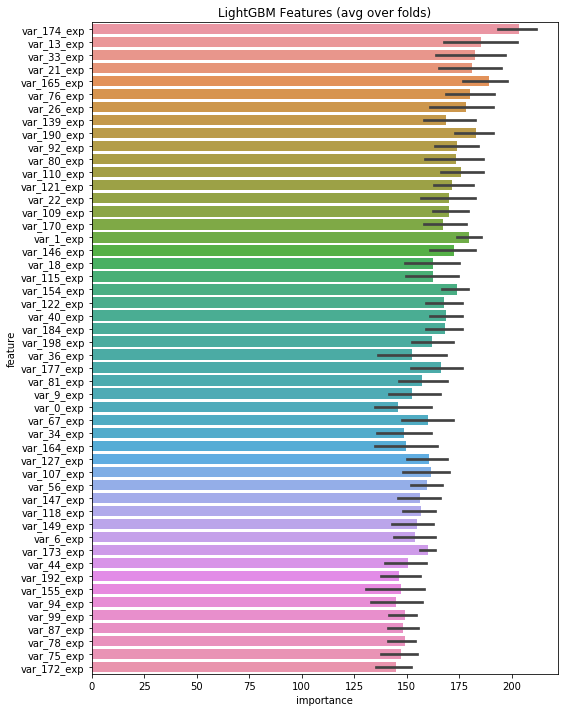

In [47]:
clfs = []
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
oof_preds = np.zeros((len(train_df), 1))
test_preds = np.zeros((len(test_df), 1))


X = train_df[feats]
y = train_df['target']
X_test = test_df[feats]
test_ids = test_df.ID_code.values


parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    #'scale_pos_weight': 400,
    #'device' : 'gpu' ,
    'boosting': 'gbdt',
    'num_leaves': 31, #31
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'learning_rate': 0.05, #0.05
    'verbose': 30
    #'min_data_in_leaf': 200
}

feature_importance_df = pd.DataFrame()
for fold_, (trn_, val_) in enumerate(folds.split(X, y)):
    print("Current Fold: {}".format(fold_+1))
    trn_x, trn_y = X.iloc[trn_, :], y[trn_]
    val_x, val_y = X.iloc[val_, :], y[val_]


    trn_lgb = lgb.Dataset(trn_x, trn_y)
    val_lgb = lgb.Dataset(val_x, val_y)
    clf = lgb.train(parameters,
                     train_set=trn_lgb,
                     #valid_sets=[valid_data_lgb,holdout_data_lgb],
                     valid_sets=[trn_lgb, val_lgb],
                     num_boost_round=3000,
                     early_stopping_rounds=50,
                     verbose_eval=False)
    


    val_pred = clf.predict(val_x)
    test_fold_pred = clf.predict(X_test)

    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
   # print('getting feature importance')
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
test_preds /= n_folds
roc_score = roc_auc_score(y, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))


print("Saving submission file")
sample = pd.read_csv('../data/sample_submission.csv')
sample.target = test_preds.astype(float)
sample.ID_code = test_ids
sample.to_csv('../submissions/{}_{}.csv'.format(model_name,str(roc_score)), index=False)

display_importances(feature_importance_df)


In [16]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [17]:


shutil.copyfile(os.path.basename(NOTEBOOK_FULL_PATH), 
                             '../models/{}_{}.ipynb'.format(model_name, str(roc_score)))


'../models/exp_and_100_cut_5_folds_0.8934789809861863.ipynb'